In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports 

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from pprint import pprint

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud


import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [68]:
df = pd.read_pickle('/content/drive/MyDrive/YouTube-Project/pre-processed-reply-merge.pkl')

In [69]:
df.shape

(47081, 10)

In [70]:
df = df.drop(['tidy_comment','tidy_comment_tokens','no_stop_joined', 'name', 'channel', 'date', 'time', 'likes'], axis=1)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47081 entries, 0 to 47080
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment         47081 non-null  object
 1   tokens_no_stop  47081 non-null  object
dtypes: object(2)
memory usage: 735.8+ KB


In [72]:
df.head()

,comment,tokens_no_stop
0,🔥 Enroll for FREE Machine Learning Course &amp...,"[enroll, free, machine, learning, course, comp..."
1,can I please get the datasets my email is tanm...,"[datasets, email, tanmaygarde]"
2,"Hi, thanks for watching our video. We have sen...","[watching, sent, requested, dataset, mail, sho..."
3,"Great video , May I request data set at reach2...","[great, request, data, reach, nirbhay]"
4,This is a great tutorial. Could you please sen...,"[great, tutorial, could, send, datasets, used,..."


### Pre-Processing

#### Remove Links

In [73]:
def remove_links(comment):
    comment_no_link = re.sub(r"http\S+", "", comment)
    return comment_no_link

In [74]:
df['comment_text_p'] = np.vectorize(remove_links)(df['comment'])

In [75]:
def remove_links(comment):
    comment_no_link = re.sub(r"youtube.com\S+", "", comment)
    return comment_no_link

In [76]:
df['comment_text_p'] = np.vectorize(remove_links)(df['comment_text_p'])

### Remove handles

In [77]:
def remove_users(comment, pattern1, pattern2):
    r = re.findall(pattern1, comment)
    for i in r:
        comment = re.sub(i, '', comment)
    
    r = re.findall(pattern2, comment)
    for i in r:
        comment = re.sub(i, '', comment)
    return comment

In [78]:
df['comment_text_p'] = np.vectorize(remove_users)(df['comment_text_p'], "@ [\w]*", "@[\w]*")

### Remove Hashtag

In [79]:
# We decided to keep hashtags because they add value to the sentiment.
# Example df.tweet_text[20]
def remove_hashtags(comment, pattern1):
    r = re.findall(pattern1, comment)
    for i in r:
        comment = re.sub(i, '', comment)
    return comment

In [80]:
df['comment_text_p'] = np.vectorize(remove_hashtags)(df['comment_text_p'], "#")

### remove collection of words

In [81]:
# It adds to the neutrality of the comment as the compound score is the sum of all words sentiment score. 
# Example df.comment_text[43]
def remove_word(comment, pattern1, pattern2):
    r = re.findall(pattern1, comment)
    for i in r:
        comment = re.sub(i, "", comment)
    r = re.findall(pattern2, comment)
    for i in r:
        comment = re.sub(i, '', comment)
    return comment

In [82]:
df['comment_text_p'] = np.vectorize(remove_word)(df['comment_text_p'], "enroll", "free")

### Remove Duplicates

In [83]:
df.drop_duplicates(subset=['comment_text_p'], keep='first', inplace=True)

In [84]:
df = df[~df.comment_text_p.str.contains("href")]

In [85]:
df.shape

(39740, 3)

### Applying VADER Sentiment Analyzer

In [86]:
# Create an object of Vader Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

In [87]:
negative = []
neutral = []
positive = []
compound = []

In [88]:
def sentiment_scores(df, negative, neutral, positive, compound):
    for i in df['comment_text_p']:
        sentiment_dict = vader_analyzer.polarity_scores(i)
        negative.append(sentiment_dict['neg'])
        neutral.append(sentiment_dict['neu'])
        positive.append(sentiment_dict['pos'])
        compound.append(sentiment_dict['compound'])

In [89]:
# Function calling 
sentiment_scores(df, negative, neutral, positive, compound)

In [90]:
# Prepare columns to add the scores later
df["negative"] = negative
df["neutral"] = neutral
df["positive"] = positive
df["compound"] = compound

In [91]:
# Fill the overall sentiment with encoding:
# (-1)Negative, (0)Neutral, (1)Positive
sentiment = []
for i in df['compound']:
    if i >= 0.05 : 
        sentiment.append(1)
  
    elif i <= - 0.05 : 
        sentiment.append(-1) 
        
    else : 
        sentiment.append(0)
df['sentiment'] = sentiment

In [92]:
neg_tweets = df.sentiment.value_counts()[-1]
neu_tweets = df.sentiment.value_counts()[0]
pos_tweets = df.sentiment.value_counts()[1]

### Number of comments by sentiment

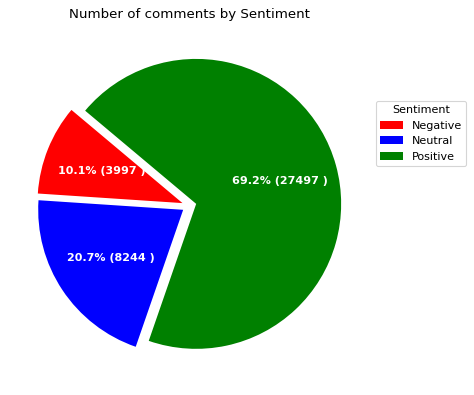

In [93]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
categories = ['Negative', 'Neutral', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['red', 'blue', 'green'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Number of comments by Sentiment", fontsize=12)
plt.show()

### Histogram

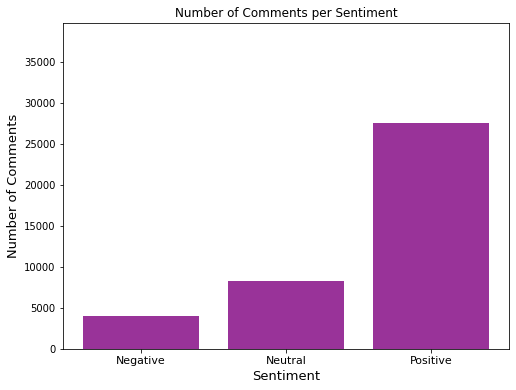

In [118]:
labels = ['Negative', 'Neutral', 'Positive']
freq = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
index = np.arange(len(freq))

plt.figure(figsize=(8,6))
plt.bar(index, freq, alpha=0.8, color= 'purple')
plt.xlabel('Sentiment', fontsize=13)
plt.ylabel('Number of Comments', fontsize=13)
plt.xticks(index, labels, fontsize=11) 
plt.title('Number of Comments per Sentiment', fontsize=12)
plt.ylim(0, len(df['comment']))
plt.show()

### Density Plot of Overall compound score

In [95]:
# We remove the neutral compound scores to compare the negative and positive tweets
data = df[(df["sentiment"]!=0)]

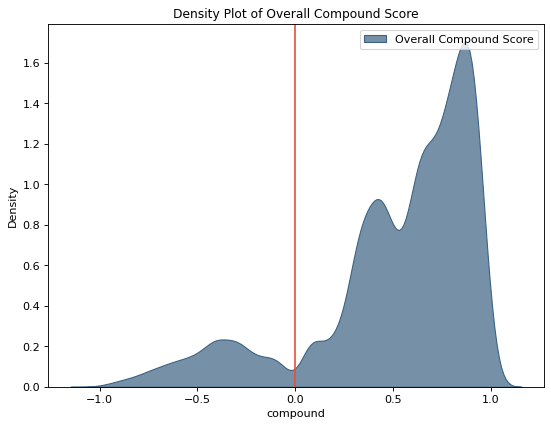

In [120]:
# Draw Plot
plt.figure(figsize=(8,6), dpi= 80)
sns.kdeplot(data["compound"], shade=True, color="#3c6382", label="Overall Compound Score", alpha=.7)

# Decoration
plt.title('Density Plot of Overall Compound Score', fontsize=11)
plt.axvline(x=0, color='#e55039')
plt.legend()
plt.show()

### Word Cloud of Positive and Negative Tweets

### Lemmatization

In [97]:
def lemmatization(comment, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    comment_out = []
    for sent in comment:
        doc = nlp(" ".join(sent)) 
        comment_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return comment_out

In [98]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [99]:
# Do lemmatization keeping only noun, adj, vb, adv
df['lemmatized'] = lemmatization(df['tokens_no_stop'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [100]:
df.drop(['tokens_no_stop'], axis=1, inplace=True)

In [101]:
df_pos = df[df['sentiment']==1]
df_neg = df[df['sentiment']==(-1)]

In [102]:
df_pos.head()

,comment,comment_text_p,negative,neutral,positive,compound,sentiment,lemmatized
5,Is it possible to get the dataset? I want to i...,Is it possible to get the dataset? I want to i...,0.000,0.808,0.192,0.4215,1,"[possible, dataset, want, implement, code, adv..."
6,"Hello, thanks for viewing our tutorial. It wou...","Hello, thanks for viewing our tutorial. It wou...",0.000,0.781,0.219,0.9042,1,"[view, tutorial, helpful, provide, email, send..."
17,"Hii,thanks for the great tutorial,could u plzz...","Hii,thanks for the great tutorial,could u plzz...",0.000,0.760,0.240,0.6249,1,"[great, tutorial, could, plzzz, send, dataset,..."
19,Thank you for the great tutorial. Can I have 1...,Thank you for the great tutorial. Can I have 1...,0.000,0.473,0.527,0.8360,1,"[great, tutorial, company, file]"
31,I wish the video should include subtitle becau...,I wish the video should include subtitle becau...,0.082,0.760,0.158,0.3182,1,"[wish, include, subtitle, intructor, voice, ha..."


In [121]:
df_pos.to_excel("df_pos.xlsx")

### WordCloud 

In [103]:
# Join the tweet back together
def rejoin_words(row):
    words = row['lemmatized']
    joined_words = (" ".join(words))
    return joined_words

In [104]:
all_words_pos = ' '.join([text for text in df_pos.apply(rejoin_words, axis=1)])
all_words_neg = ' '.join([text for text in df_neg.apply(rejoin_words, axis=1)])

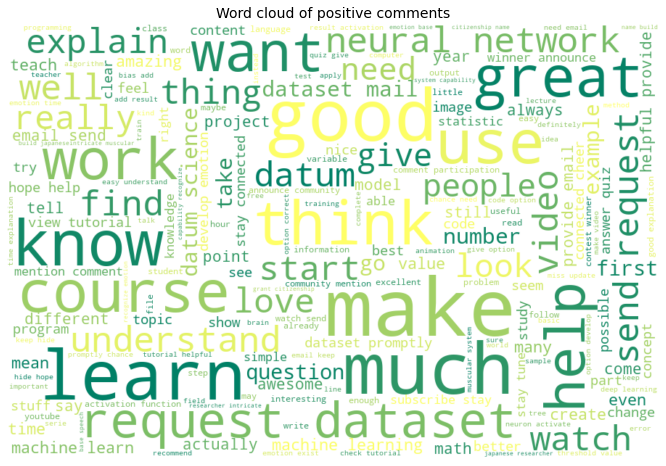

In [105]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=200,colormap='summer').generate(all_words_pos)

plt.figure(figsize=(12, 8))
# plt.title('WordCloud of Positive comments', fontsize=14, fontweight="bold")
plt.title('Word cloud of positive comments', fontsize=14)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

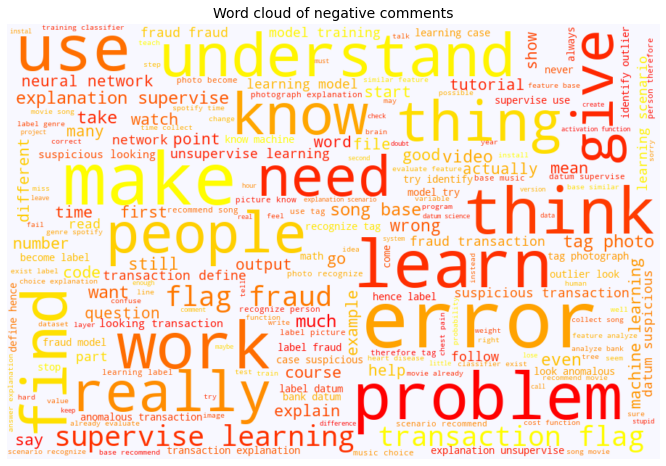

In [106]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=200,colormap='autumn').generate(all_words_neg)

plt.figure(figsize=(12, 8))
# plt.title('WordCloud of Negative comments', fontsize=14, fontweight="bold")
plt.title('Word cloud of negative comments', fontsize=14)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Compound Score Distribution 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


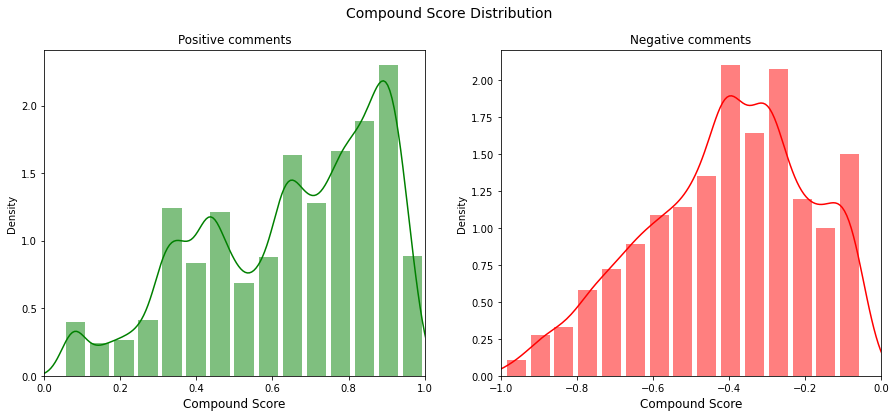

In [107]:
x1 = df_pos['compound']
x2 = df_neg['compound']
plt.figure(figsize=(15,6))
plt.suptitle('Compound Score Distribution', fontsize=14)
plt.subplot(1,2,1)

sns.distplot(x1, color="g", bins=15, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title('Positive comments',fontsize=12)
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([0,1])

# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x2, color="r", bins=15, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Negative comments",fontsize=12)
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([-1,0])

plt.show()

In [108]:
x1.describe()

count    27498.000000
mean         0.645571
std          0.234244
min          0.051600
25%          0.449700
50%          0.690000
75%          0.848100
max          0.999200
Name: compound, dtype: float64

In [109]:
x2.describe()

count    3997.000000
mean       -0.406853
std         0.212404
min        -0.990500
25%        -0.552500
50%        -0.401900
75%        -0.250000
max        -0.051600
Name: compound, dtype: float64

### Box Plot

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


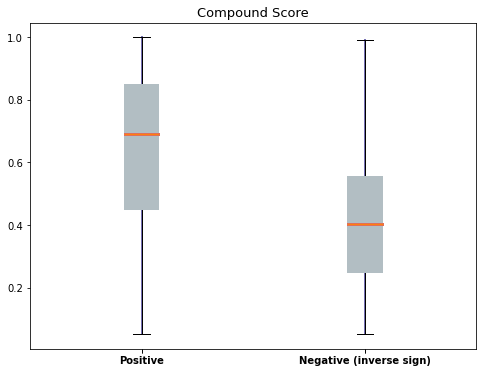

In [110]:
data_to_plot = [x1,(x2)*-1]
# Box-plot
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot, patch_artist=True)
for box in bp['boxes']:
    # change outline color
    box.set( color='#b2bec3', linewidth=2)
## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
for median in bp['medians']:
    median.set(color='#e17055', linewidth=3)
plt.boxplot(data_to_plot)
plt.title('Compound Score', fontsize=13)
ax.set_xticklabels(['Positive', 'Negative (inverse sign)'], fontweight='bold')
plt.show()

### 10 Most Positive and Negative comments

In [111]:
# 10 Most positive comments
df_pos.sort_values('compound', inplace=True, ascending=False)
df_pos.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [112]:
df_pos.head(10)

,comment,comment_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,Nice video! I&#39;m not familiar with your cha...,Nice video! I&39;m not familiar with your chan...,0.029,0.755,0.216,0.9992,1,"[nice, familiar, channel, thumbnail, length, c..."
1,As we making progress developing AI that will ...,As we making progress developing AI that will ...,0.085,0.757,0.158,0.9972,1,"[make, progress, develop, create, sort, consci..."
2,One of the viewers reached out to me via email...,One of the viewers reached out to me via email...,0.019,0.831,0.149,0.9969,1,"[viewer, reach, email, think, share, else, cur..."
3,(...continued) (2)<br><br>It wasn&#39;t until ...,(...continued) (2)<br><br>It wasn&39;t until I...,0.018,0.882,0.099,0.9967,1,"[continue, start, work, graphic, application, ..."
4,I imagined the nodes as flexible water balloon...,I imagined the nodes as flexible water balloon...,0.018,0.848,0.134,0.9965,1,"[imagine, node, flexible, water, balloon, conn..."
5,Always nice to know your not alone in the worl...,Always nice to know your not alone in the worl...,0.032,0.741,0.227,0.9955,1,"[always, nice, know, alone, world, young, guy,..."
6,NOW<br>the last digit with meaning must always...,NOW<br>the last digit with meaning must always...,0.007,0.851,0.141,0.9955,1,"[last, digit, meaning, must, always, cluster, ..."
7,Couldn&#39;t help but type in Comment #300<br>...,Couldn&39;t help but type in Comment 300<br><b...,0.038,0.810,0.152,0.9945,1,"[help, type, comment, love, mathematician, rea..."
8,~roughly:<br>It starts with the 784 values [28...,~roughly:<br>It starts with the 784 values [28...,0.027,0.802,0.171,0.9943,1,"[roughly, start, value, represent, original, i..."
9,"I have only seen this video so far, but I deci...","I have only seen this video so far, but I deci...",0.027,0.823,0.150,0.9942,1,"[see, decide, series, base, first, impression,..."


In [113]:
# 10 Most Negative Tweets
df_neg.sort_values('compound', inplace=True)
df_neg.reset_index(drop=True).head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,comment,comment_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,"This isn&#39;t really related to this subject,...","This isn&39;t really related to this subject, ...",0.205,0.727,0.068,-0.9905,-1,"[really, relate, subject, resist, take, police..."
1,Revelation 20:13-15 (KJV) And the sea gave up...,Revelation 20:13-15 (KJV) And the sea gave up...,0.336,0.664,0.000,-0.9854,-1,"[revelation, give, dead, death, hell, deliver,..."
2,Revelation 20:13-15 (KJV) And the sea gave up...,Revelation 20:13-15 (KJV) And the sea gave up...,0.315,0.685,0.000,-0.9834,-1,"[revelation, give, dead, death, hell, deliver,..."
3,All humans natural brain is converted into art...,All humans natural brain is converted into art...,0.224,0.725,0.051,-0.9825,-1,"[human, natural, brain, convert, artificial, b..."
4,"​@Suwarna choudhary God, It&#39;s been a year ...","​ choudhary God, It&39;s been a year since tha...",0.167,0.754,0.078,-0.9757,-1,"[choudhary, year, comment, post, help, much, w..."
5,"Dear Grant,<br>I worked out y=x^x (x to the po...","Dear Grant,<br>I worked out y=x^x (x to the po...",0.165,0.778,0.057,-0.9756,-1,"[dear, work, power, find, approach, also, mini..."
6,"Being familiar with actual neurons myself: no,...","Being familiar with actual neurons myself: no,...",0.169,0.831,0.000,-0.9742,-1,"[familiar, actual, neuron, neural, network, mu..."
7,I swear it is literally impossible to set up t...,I swear it is literally impossible to set up t...,0.162,0.799,0.039,-0.9720,-1,"[swear, literally, impossible, environment, us..."
8,You really get it. The math.<br>Where were you...,You really get it. The math.<br>Where were you...,0.146,0.819,0.035,-0.9676,-1,"[really, math, many, year, good, clear, number..."
9,ERROR: astroid 2.2.5 requires typed-ast&gt;=1....,ERROR: astroid 2.2.5 requires typed-ast&gt;=1....,0.095,0.871,0.034,-0.9662,-1,"[error, astroid, require, type, implementation..."


### Trying and Testing on specific comments

In [114]:
df.head(10)

,comment,comment_text_p,negative,neutral,positive,compound,sentiment,lemmatized
5,Is it possible to get the dataset? I want to i...,Is it possible to get the dataset? I want to i...,0.000,0.808,0.192,0.4215,1,"[possible, dataset, want, implement, code, adv..."
6,"Hello, thanks for viewing our tutorial. It wou...","Hello, thanks for viewing our tutorial. It wou...",0.000,0.781,0.219,0.9042,1,"[view, tutorial, helpful, provide, email, send..."
17,"Hii,thanks for the great tutorial,could u plzz...","Hii,thanks for the great tutorial,could u plzz...",0.000,0.760,0.240,0.6249,1,"[great, tutorial, could, plzzz, send, dataset,..."
19,Thank you for the great tutorial. Can I have 1...,Thank you for the great tutorial. Can I have 1...,0.000,0.473,0.527,0.8360,1,"[great, tutorial, company, file]"
21,can I get the slide used in this tutorial?,can I get the slide used in this tutorial?,0.000,1.000,0.000,0.0000,0,"[slide, use, tutorial]"
31,I wish the video should include subtitle becau...,I wish the video should include subtitle becau...,0.082,0.760,0.158,0.3182,1,"[wish, include, subtitle, intructor, voice, ha..."
32,Thank you for your review. We are sorry to hea...,Thank you for your review. We are sorry to hea...,0.101,0.713,0.186,0.5632,1,"[hear, frustrating, experience, really, apprec..."
35,Will you please again explain that how to find...,Will you please again explain that how to find...,0.000,0.571,0.429,0.8402,1,"[explain, find, good, line, linear, regression]"
37,Dene waala jab bhi deta deta chhapar phad ke t...,Dene waala jab bhi deta deta chhapar phad ke t...,0.000,0.603,0.397,0.8481,1,"[deta, chhapar, phad, thankyou, amazing, cours..."
41,stuck with out csv. kindly help,stuck with out csv. kindly help,0.183,0.275,0.541,0.5994,1,"[kindly, help]"


#### Normalization used by VADER
#### $latex \large \dfrac{x}{\sqrt{x^2 + \alpha}}$

### Save Results as a Dataframe

In [115]:
df.drop(['comment_text_p', 'lemmatized'], axis=1, inplace=True)

In [116]:
df.to_pickle('/content/drive/MyDrive/YouTube-Project/vader-sentiment.pkl')